#### A parquet

In [2]:
import pandas as pd
import xarray as xr
from concurrent.futures import ThreadPoolExecutor

def convert_csv_to_parquet(ruta_csv, ruta_parquet_csv):
    df_csv = pd.read_csv(ruta_csv)

    df_csv.to_parquet(ruta_parquet_csv, engine='pyarrow')
    print(f"Archivo CSV convertido a Parquet: {ruta_parquet_csv}")

def convert_nc_to_parquet(ruta_nc, ruta_parquet_nc):
    ds_nc = xr.open_dataset(ruta_nc)
    df_nc = ds_nc.to_dataframe().reset_index()
    df_nc.to_parquet(ruta_parquet_nc, engine='pyarrow')
    print(f"Archivo NetCDF convertido a Parquet: {ruta_parquet_nc}")

ruta_csv = 'Dades/estaciones_final_inputed.csv'
ruta_parquet_csv = 'Dades/estaciones.parquet'
ruta_nc = 'Dades/combinedERA5.nc'
ruta_parquet_nc = 'Dades/ERA5spain.parquet'

with ThreadPoolExecutor(max_workers=2) as executor:
    executor.submit(convert_csv_to_parquet, ruta_csv, ruta_parquet_csv)
    executor.submit(convert_nc_to_parquet, ruta_nc, ruta_parquet_nc)


Archivo CSV convertido a Parquet: Dades/estaciones.parquet


#### KDTREE

In [3]:
import pandas as pd

ruta_parquet_csv = 'Dades/estaciones.parquet'
ruta_parquet_nc = 'Dades/ERA5spain.parquet'

df_estaciones = pd.read_parquet(ruta_parquet_csv)
df_climaticos = pd.read_parquet(ruta_parquet_nc)

df_estaciones['FECHA'] = pd.to_datetime(df_estaciones['FECHA'])
df_climaticos['time'] = pd.to_datetime(df_climaticos['time'])

In [4]:
df_climaticos

,longitude,latitude,time,t2m,u10,v10,sp,ssrd,tp
0,-10.0,44.0,2018-01-01 00:00:00,287.197998,13.642319,5.753589,102387.007812,0.0,0.000030
1,-10.0,44.0,2018-01-01 01:00:00,287.417542,14.126425,6.126161,102363.210938,0.0,0.000069
2,-10.0,44.0,2018-01-01 02:00:00,287.528320,14.790117,6.008506,102368.671875,0.0,0.000026
3,-10.0,44.0,2018-01-01 03:00:00,287.613922,14.464778,6.421603,102240.343750,0.0,0.000002
4,-10.0,44.0,2018-01-01 04:00:00,287.662231,14.873405,6.490889,102267.640625,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
70535515,5.0,36.0,2022-12-31 19:00:00,281.809448,-0.714918,1.714782,90833.140625,0.0,0.000000
70535516,5.0,36.0,2022-12-31 20:00:00,280.765167,-1.018135,1.376853,90837.039062,0.0,0.000000
70535517,5.0,36.0,2022-12-31 21:00:00,278.748108,-1.005772,1.407573,90847.570312,0.0,0.000000
70535518,5.0,36.0,2022-12-31 22:00:00,276.950562,-1.074093,1.272271,90820.265625,0.0,0.000000


In [2]:
import pandas as pd
from scipy.spatial import KDTree
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np



def combinar_datos_fecha_hora(fecha_hora, df_estaciones, df_climaticos):
    try:
        df_estaciones_filtrado = df_estaciones[df_estaciones['FECHA'].dt.floor('h') == fecha_hora]
        df_climaticos_filtrado = df_climaticos[df_climaticos['time'].dt.floor('h') == fecha_hora]
        
        if df_estaciones_filtrado.empty or df_climaticos_filtrado.empty:
            return pd.DataFrame() 
        kdtree_temp = KDTree(df_climaticos_filtrado[['longitude', 'latitude']])
        
        combined_data = []
        for _, row in df_estaciones_filtrado.iterrows():
            distance, index_closest = kdtree_temp.query([row['LONGITUD_G'], row['LATITUD_G']])
            closest_match = df_climaticos_filtrado.iloc[index_closest].to_dict()
            
            combined_row = {**row.to_dict(), **closest_match}
            combined_data.append(combined_row)
        
        return pd.DataFrame(combined_data)
    
    except Exception as e:
        print(f"Error procesando {fecha_hora}: {e}")
        return pd.DataFrame()


fechas_horas_unicas = pd.Series(np.unique(df_estaciones['FECHA'].dt.floor('h'))) 

df_combinado_final = pd.DataFrame()

with ThreadPoolExecutor(max_workers=60) as executor:  
    futures = {executor.submit(combinar_datos_fecha_hora, fecha_hora, df_estaciones, df_climaticos): fecha_hora for fecha_hora in fechas_horas_unicas}
    
    for future in as_completed(futures):
        fecha_hora = futures[future]
        try:
            df_resultado = future.result()
            df_combinado_final = pd.concat([df_combinado_final, df_resultado], ignore_index=True)
            print(f"Procesamiento completado para: {fecha_hora}")
        except Exception as e:
            print(f"Error en el procesamiento de: {fecha_hora} con error {e}")


df_combinado_final.to_parquet('Dades/dataset_combinado_final.parquet', engine='pyarrow')

Procesamiento completado para: 2018-01-01 07:00:00
Procesamiento completado para: 2018-01-01 11:00:00
Procesamiento completado para: 2018-01-01 22:00:00
Procesamiento completado para: 2018-01-01 08:00:00
Procesamiento completado para: 2018-01-01 21:00:00
Procesamiento completado para: 2018-01-01 09:00:00
Procesamiento completado para: 2018-01-01 01:00:00
Procesamiento completado para: 2018-01-02 04:00:00
Procesamiento completado para: 2018-01-01 18:00:00
Procesamiento completado para: 2018-01-01 03:00:00
Procesamiento completado para: 2018-01-01 16:00:00
Procesamiento completado para: 2018-01-02 01:00:00
Procesamiento completado para: 2018-01-03 01:00:00
Procesamiento completado para: 2018-01-01 04:00:00
Procesamiento completado para: 2018-01-01 10:00:00
Procesamiento completado para: 2018-01-02 22:00:00
Procesamiento completado para: 2018-01-02 06:00:00
Procesamiento completado para: 2018-01-01 17:00:00
Procesamiento completado para: 2018-01-01 06:00:00
Procesamiento completado para: 

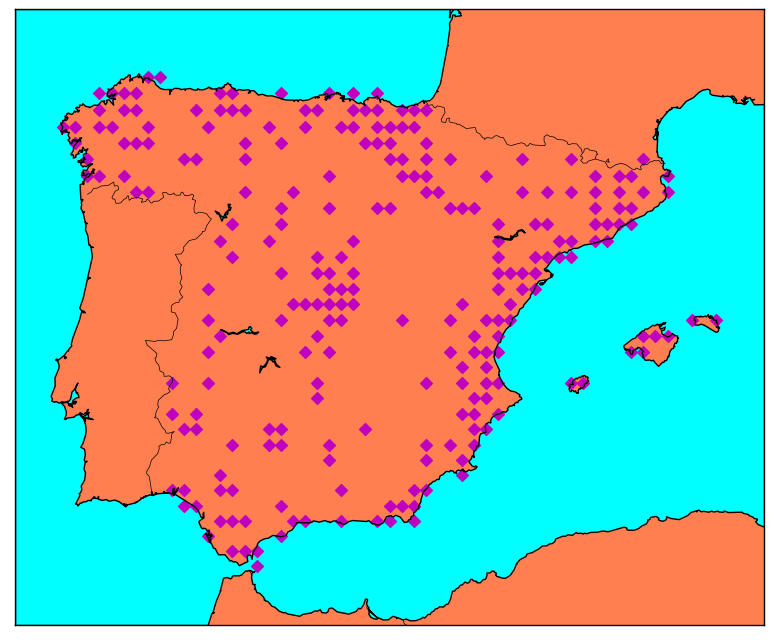

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

coordenadas_unicas = df_combinado_final[['latitude', 'longitude']].drop_duplicates()

plt.figure(figsize=(10, 8))

mapa = Basemap(projection='merc', llcrnrlat=coordenadas_unicas.latitude.min() - 1, 
               urcrnrlat=coordenadas_unicas.latitude.max() + 1, 
               llcrnrlon=coordenadas_unicas.longitude.min() - 1, 
               urcrnrlon=coordenadas_unicas.longitude.max() + 1, 
               resolution='i')

mapa.drawcoastlines()
mapa.drawcountries()
mapa.drawmapboundary(fill_color='aqua')
mapa.fillcontinents(color='coral',lake_color='aqua')

x, y = mapa(coordenadas_unicas.longitude.values, coordenadas_unicas.latitude.values)

mapa.scatter(x, y, marker='D',color='m')

plt.show()
